# Simple Trend following Strategy

I am testing a very simple trend following strategy based on moving average. The research is to find different in/out protocal's influence on Sharpe Ratio / MDD

## 4 types of entering / exit protocals

- Enter: MA21 > MA5 or MA5-MA120 > SD, Exit: MA21 <= MA 5 and MA5 - MA120 <= SD
- Enter: close > MA30 and MA10 > MA120, Exit: close <= MA30 or MA10 <= MA120
- Enter: MA5 > MA120 and MA5 - MA120 > SD, Exit: MA5 <= MA120 or MA5 - MA120 <= SD
- Enter: MA5 - MA120 > SD  and close > MA30, Exit: MA5 - MA120 <= SD  or close <= MA30

## Basic Assumption
- No transaction fees
- Buy / sell at close
- Cannot short
- Risk free rate is 2.5%
- SD = 0.05
## Underlying Asset
- SP500

In [1]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import json
import requests
import pandas as pd

In [2]:
start_money = 100000
risk_free = 0.025
ticker = 'SPY'
mmd = []
sharpe = []

In [3]:
# Some utility functions
def MMD(w):
    max_so_far = w[0]
    drawdown_so_far = []
    for i in w:
        max_so_far = max(max_so_far,i)
        drawdown = i / max_so_far - 1 
        drawdown_so_far.append(drawdown)
    max_drawdown = min(drawdown_so_far)
    return max_drawdown


def get_sharpe_ratio(w):
    total_return = w.iloc[-1] / start_money - 1
    annual_return = w.diff().mean() * 255
    annual_std = w.diff().std() * np.sqrt(255)
    sharpe_ratio = (annual_return - risk_free) / annual_std
    return sharpe_ratio

In [4]:
# Get data from IEX
url = f"https://api.iextrading.com/1.0/stock/{ticker}/chart/5y"
data1 = json.loads(requests.get(url).content.decode())
df = pd.read_json(url)[['date', 'close']].copy()
df= df[['date', 'close']]
df['ma5'] = df['close'].rolling(5).mean()
df['ma21'] = df['close'].rolling(21).mean()
df['ma30'] = df['close'].rolling(30).mean()
df['ma120'] = df['close'].rolling(120).mean()
df['ma10'] = df['close'].rolling(10).mean()
SD = 0.05
df = df.dropna()
df.head()

,date,close,ma5,ma21,ma30,ma120,ma10
119,2014-03-21,170.3724,170.42910,169.844381,168.755870,163.389703,170.16415
120,2014-03-24,169.6678,170.41416,169.946671,168.955313,163.535046,169.98997
121,2014-03-25,170.4730,170.31794,170.043057,169.171577,163.677056,169.98103
122,2014-03-26,169.2469,170.15870,170.084095,169.287147,163.810057,169.84493
123,2014-03-27,168.8901,169.73004,170.107705,169.388093,163.951862,169.86445


### Strategy A: Enter: MA21 > MA5 or MA5-MA120 > SD, Exit: MA21 <= MA 5 and MA5 - MA120 <= SD

In [5]:
cash = [start_money]
stock = [0]
net1 = [start_money]
for idx, row in df.iterrows():
    if row.ma21>row.ma5 or row.ma5 - row.ma120 >SD:
        # buy
        shares_to_buy = int(cash[-1] / row.close)
        cost = shares_to_buy * row.close
        cash.append(cash[-1] - cost)
        stock.append(stock[-1] + shares_to_buy)
    else:
        # sell
        cash.append(cash[-1] + stock[-1] * row.close)
        stock.append(0)
    net1.append(stock[-1] * row.close + cash[-1])

### Plot Return

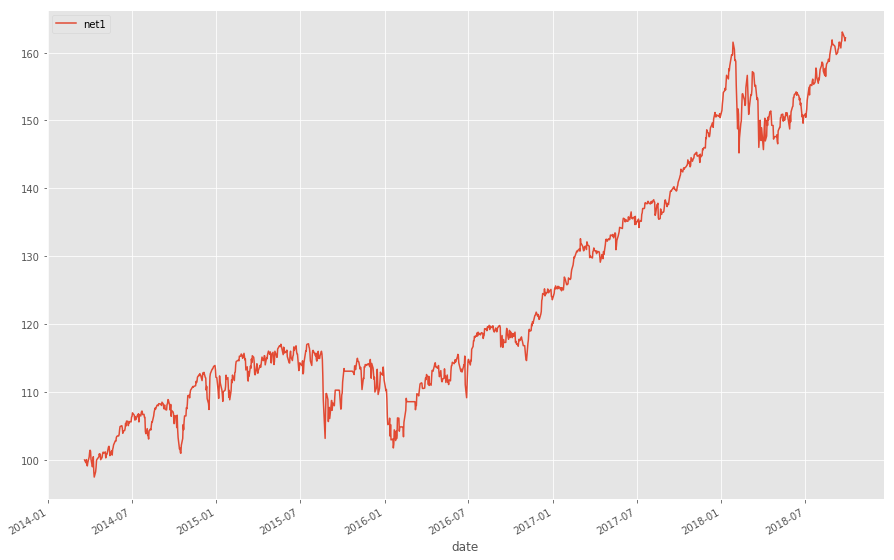

In [6]:
df['net1'] = net1[1:]
df['cash'] = cash[1:]
df['stock'] = stock[1:]
df['net1'] = df['net1'] / start_money * 100
mmd.append(MMD(df['net1'].values))
sharpe.append(get_sharpe_ratio(df['net1']))
df[['date', 'net1']].set_index("date").plot(figsize=(15,10))

### Strategy B : Enter: close > MA30 and MA10 > MA120, Exit: close <= MA30 or MA10 <= MA120

In [7]:
cash = [start_money]
stock = [0]
net2 = [start_money]
for idx, row in df.iterrows():
    if row.close > row.ma30 or row.ma10 > row.ma120:
        # buy
        shares_to_buy = int(cash[-1] / row.close)
        cost = shares_to_buy * row.close
        cash.append(cash[-1] - cost)
        stock.append(stock[-1] + shares_to_buy)
    else:
        # sell
        cash.append(cash[-1] + stock[-1] * row.close)
        stock.append(0)
    net2.append(stock[-1] * row.close + cash[-1])

### Plot Return

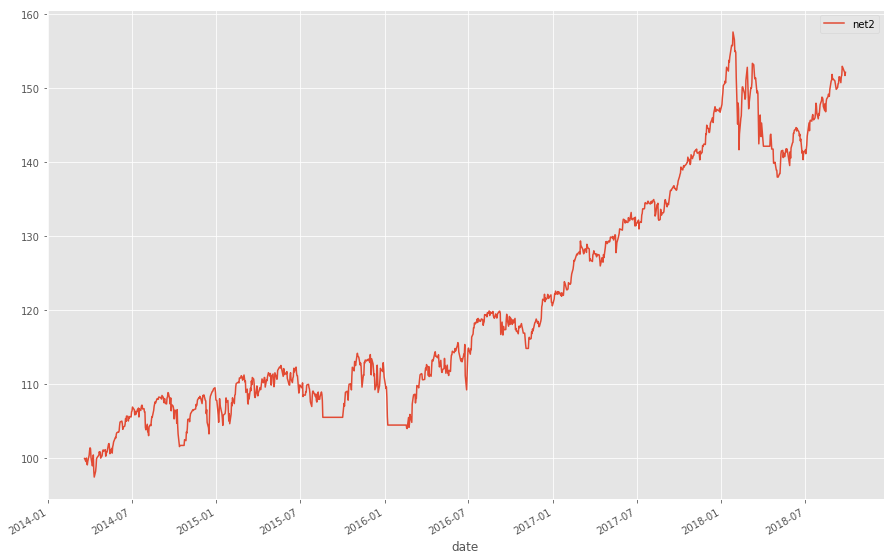

In [8]:
df['net2'] = net2[1:]
df['cash'] = cash[1:]
df['stock'] = stock[1:]
df['net2'] = df['net2'] / start_money * 100
df[['date', 'net2']].set_index('date').plot(figsize=(15,10))

In [9]:
mmd.append(MMD(df['net2'].values))
sharpe.append(get_sharpe_ratio(df['net2']))

### Strategy C: Enter: MA5 > MA120 and MA5 - MA120 >SD, Exit: MA5 <= MA120 or MA5 - MA120 <= SD

In [10]:
cash = [start_money]
stock = [0]
net3 = [start_money]

for idx, row in df.iterrows():
    if row.ma5 > row.ma120 and row.ma5 - row.ma120 > SD :
        # buy
        shares_to_buy = int(cash[-1] / row.close)
        cost = shares_to_buy * row.close
        cash.append(cash[-1] - cost)
        stock.append(stock[-1] + shares_to_buy)
    else:
        cash.append(cash[-1] + stock[-1] * row.close)
        stock.append(0)
    net3.append(stock[-1] * row.close + cash[-1])

### Plot Return

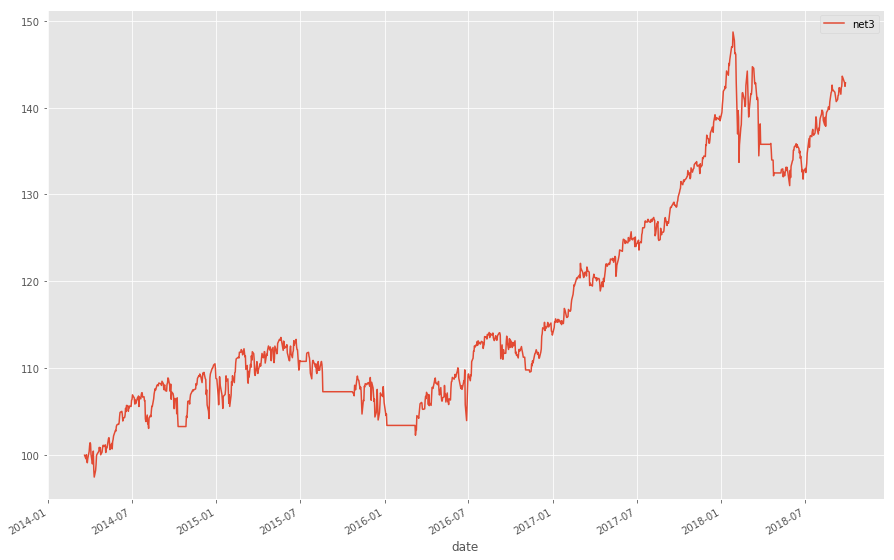

In [11]:
df['net3'] = net3[1:]
df['cash'] = cash[1:]
df['stock'] = stock[1:]
df['net3'] = df['net3'] / start_money * 100
df[['date', 'net3']].set_index('date').plot(figsize=(15,10))

In [12]:
mmd.append(MMD(df['net3'].values))
sharpe.append(get_sharpe_ratio(df['net3']))

### Streatgy D: Enter: MA5 - MA 120 >SD  and close > MA30, Exit: MA5 - MA120 <= SD  or close <= MA30

In [15]:
start_money = 100000

cash = [start_money]
stock = [0]
net4 = [start_money]

for idx, row in df.iterrows():
    if row.ma30 >row.close and row.ma5 - row.ma120 > SD :
        shares_to_buy = int(cash[-1] / row.close)
        cost = shares_to_buy * row.close
        cash.append(cash[-1] - cost)
        stock.append(stock[-1] + shares_to_buy)
    else:
        cash.append(cash[-1] + stock[-1] * row.close)
        stock.append(0)
    net4.append(stock[-1] * row.close + cash[-1])

### Plot Return

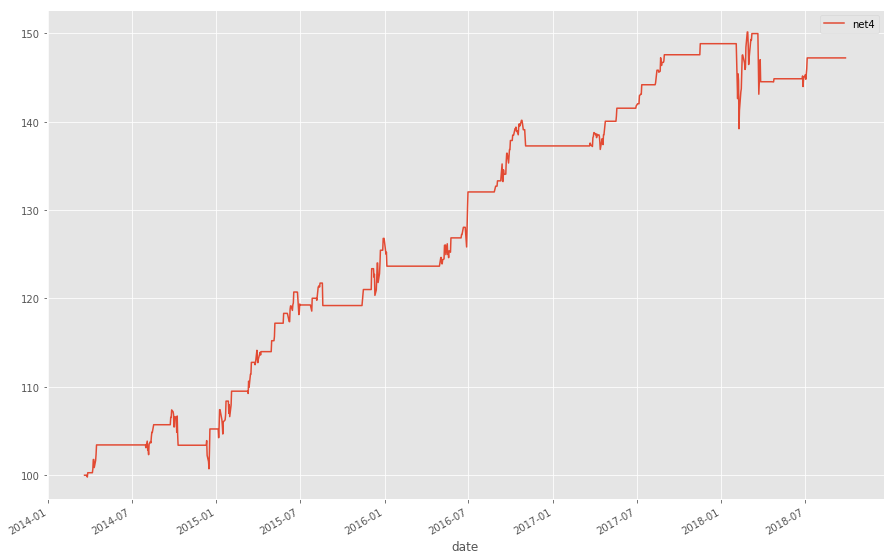

In [16]:
df['net4'] = net4[1:]
df['cash'] = cash[1:]
df['stock'] = stock[1:]
df['net4'] = df['net4'] / start_money * 100
df[['date', 'net4']].set_index('date').plot(figsize=(15,10))

In [17]:
mmd.append(MMD(df['net4'].values))
sharpe.append(get_sharpe_ratio(df['net4']))

In [18]:
data = pd.DataFrame({'Strategy':['Strategy A','Strategy B','Strategy C','Strategy D'],
       'Total Return(%)': [(i / 100 - 1) * 100 for i in [df['net1'].iloc[-1] ,df['net2'].iloc[-1], df['net3'].iloc[-1], df['net4'].iloc[-1]]],
        "Annual Return(%)": [df[i].pct_change().mean() * 255 * 100 for i in ["net1", "net2", "net3", "net4"]],
       'Max Drawdown(%)':mmd,
       'Sharpe Ratio':sharpe})

In [19]:
data[["Strategy", "Total Return(%)", "Annual Return(%)", "Max Drawdown(%)", "Sharpe Ratio"]]

,Strategy,Total Return(%),Annual Return(%),Max Drawdown(%),Sharpe Ratio
0,Strategy A,62.159038,11.563950,-0.130998,0.935196
1,Strategy B,52.171010,9.982051,-0.124383,0.884988
2,Strategy C,42.838697,8.508524,-0.118893,0.789372
3,Strategy D,47.194995,8.911409,-0.064660,1.152182
